In [43]:
import redis
import time
import numpy as np
import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import scipy.interpolate as interpolate
import scipy.signal
import pandas as pd

# Load data

In [55]:
#r = redis.Redis(host='192.168.178.168', port=6379, db=0)
r = redis.Redis(host='localhost', port=6379, db=0)

In [56]:
read_samples = r.xread({'accel':b"0-0"})

In [57]:
samples = read_samples[0][1][:]
print(len(samples))

1808593


In [58]:
samples[-1][1]

{b't': b'5807',
 b't_realtime': b'1574411264159',
 b'x': b'603.0',
 b'y': b'6.0',
 b'z': b'-722.0',
 b'activity': b'1.0000',
 b'diff': b'14.33',
 b'delay': b'2.00',
 b'state': b'0'}

In [59]:
import dateutil.parser


In [60]:
# from https://stackoverflow.com/questions/33137741/fastest-way-to-convert-a-dicts-keys-values-from-bytes-to-str-in-python3
def convert_from_bytes(data):
    if isinstance(data, bytes):      return data.decode()
    if isinstance(data, dict):       return dict(map(convert_from_bytes, data.items()))
    if isinstance(data, tuple):      return tuple(map(convert_from_bytes, data))

In [61]:
result_dict = {}

ts = []
raw = np.zeros((len(samples), 3))

for i, s in enumerate(samples):
    s = s[1]
    s = convert_from_bytes(s)
    milli = int(float(s['t_realtime']))
    
    ts.append(milli)
    for k, coord in enumerate(['x', 'y', 'z']):
        raw[i, k] = int(float(s[coord]))
        
    result_dict[i] = s
ts = np.array(ts)    
df = pd.DataFrame.from_dict(result_dict, "index")  
for col in df.columns:
    df[col] = pd.to_numeric(df[col])

In [62]:
times = []
for i, milli in enumerate(ts):
    times.append(datetime.datetime.fromtimestamp(milli/1000.0))
times = np.array(times)
df['time'] = times

## Calculate diff of coordinates

In [63]:
diffs = np.mean(raw, axis=1)
diffs = np.diff(diffs, axis=0)
diffs = np.abs(diffs)
diffs = np.insert(diffs, 0, 0)
df['diff'] = diffs

## Select specific time window for analysis

In [64]:
print("Data from {} to {}". format(df.time.iloc[0], df.time.iloc[-1]))

Data from 2019-11-10 03:58:21.769000 to 2019-11-22 09:27:44.159000


In [67]:
time_selector = (df.time >= '2019-11-22 00:00:00') & (df.time <= '2019-11-22 12:00:00')
selected_df = df.loc[time_selector]
# reset data arrays
ts = np.array(selected_df['t_realtime'])
times = np.array(selected_df['time'])
diffs = np.array(selected_df['diff'])

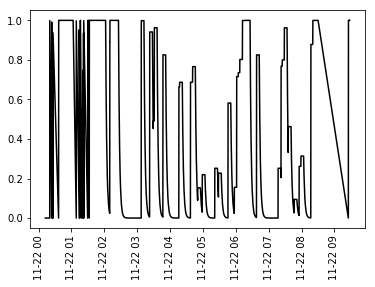

In [68]:
plt.plot(selected_df['time'], selected_df['activity'], 'k', zorder=0)
plt.gca().xaxis.set_tick_params(rotation=90)

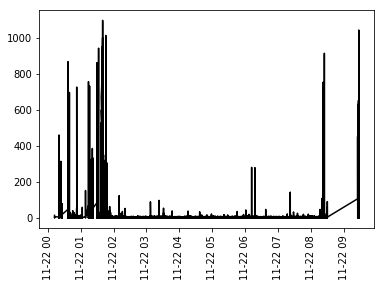

In [69]:
plt.plot(times, diffs, 'k', zorder=0)
plt.gca().xaxis.set_tick_params(rotation=90)

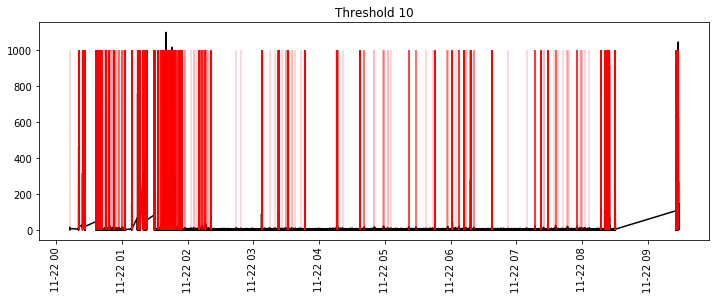

In [72]:
for thr in [10]:
    plt.figure(figsize=(12, 4))
    plt.plot(times, diffs, 'k', zorder=0)

    plt.vlines(times[np.argwhere(diffs>thr)], 0, 1000, color='red', zorder=1, alpha=0.2)
    plt.gca().xaxis.set_tick_params(rotation=90)
    plt.title("Threshold {}".format(thr))
    plt.show()

## Resample: Evenly space data

In [73]:
int((ts[-1] - ts[1]) / 10)

3332177

In [1730]:
f = interpolate.interp1d(ts, diffs, kind='linear')
sampling_distance = int((ts[-1] - ts[1]) / 10) # 10 ms
even_ts = np.linspace(ts[1], ts[-1], sampling_distance)
even_diff = f(even_ts)
even_hours = np.array([datetime.datetime.fromtimestamp(milli/1000.0) for milli in even_ts])

print("Samples before: {} after: {}".format(len(ts), len(even_ts)))

Samples before: 129966 after: 2644726


(0, 50)

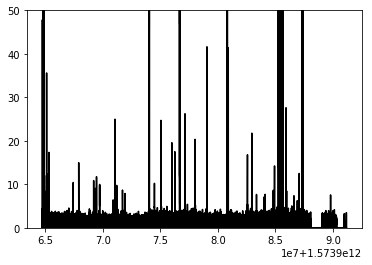

In [1731]:
# highpass filter interpolated data 
# so long times of inactivity and motion between
# recording sessinos are not treated as activity

raw_data = even_diff
fs = 1 / ((even_ts[1] - even_ts[0]) / 1000)  # Sampling frequency

fc = 1  # Cut-off frequency of the filter
w = fc / (fs / 2) # Normalize the frequency
b, a = scipy.signal.butter(5, w, 'high')
filtered_data = scipy.signal.filtfilt(b, a, raw_data)
filtered_data = np.abs(filtered_data)
even_diff = filtered_data

plt.plot(even_ts, even_diff, c='k')
plt.ylim(0, 50)

In [1732]:
result_dict = {}
for i, even_t in enumerate(even_ts):
    result_dict[i] = {"t" : even_t, "h" : even_hours[i], "diff" : even_diff[i]}
even_df = pd.DataFrame.from_dict(result_dict, "index")

In [1733]:
even_hours[0].strftime('%d.%m.%Y (%H:%M:%S)')

'17.11.2019 (05:25:21)'

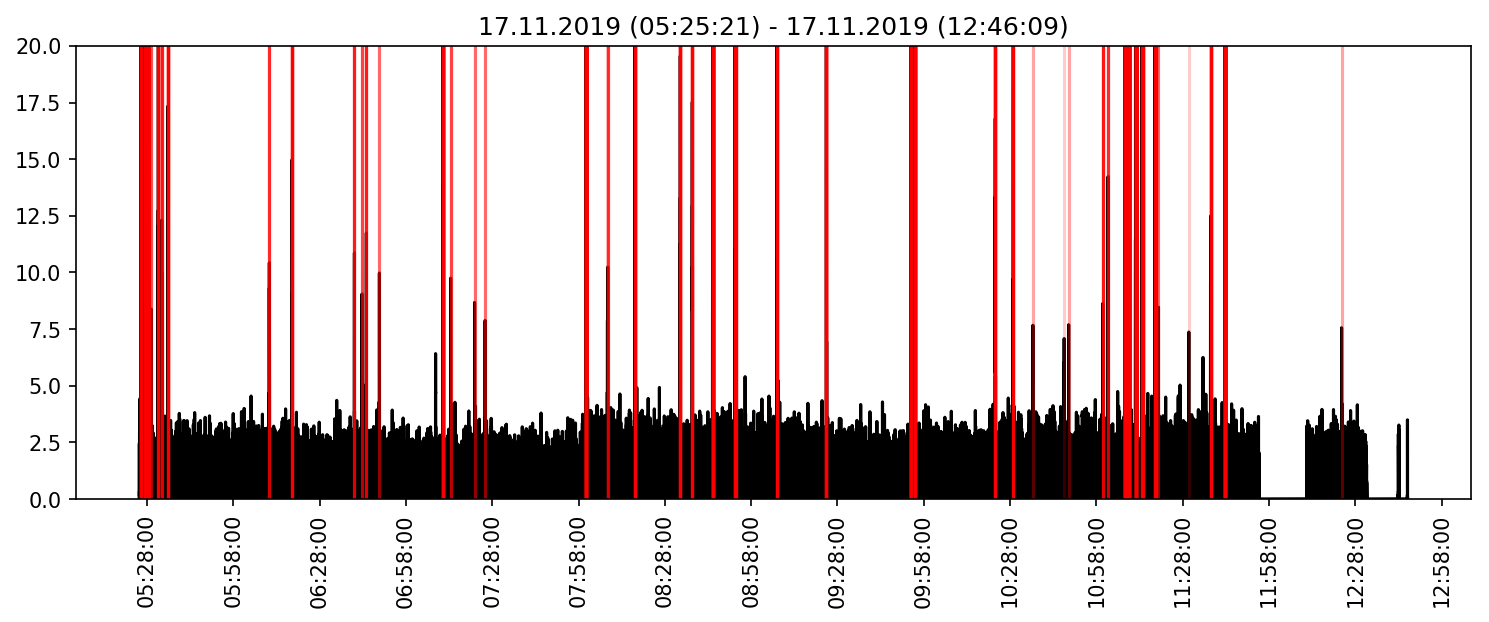

In [1734]:
import matplotlib.dates as mdates
hours = mdates.MinuteLocator(interval = 30)
h_fmt = mdates.DateFormatter('%H:%M:%S')

plt.figure(figsize=(12, 4), dpi=(150))
plt.plot(even_hours, even_diff, 'k', zorder=0)
thr = 7

plt.vlines(even_hours[np.argwhere(even_diff>thr)], 0, 100, color='red', zorder=1, alpha=0.2)

plt.title("{} - {}".format(even_hours[0].strftime('%d.%m.%Y (%H:%M:%S)'), even_hours[-1].strftime('%d.%m.%Y (%H:%M:%S)')))
plt.gca().xaxis.set_tick_params(rotation=90)
plt.gca().xaxis.set_major_locator(hours)
plt.gca().xaxis.set_major_formatter(h_fmt)

plt.ylim(0, 20)
plt.show()

# Nonlinear model

In [37]:
# nonliear model
activity = np.zeros((len(even_ts)))
dt = 0.1
decay = 2000.0
spike_strength = 0.06

thresh = even_diff>thr
for i in range(0, len(even_ts)-1):
    activity_rhs = - activity[i]/decay + (1 - activity[i]) * spike_strength * thresh[i] / dt
    activity[i+1] = activity[i] + activity_rhs * dt

NameError: name 'even_ts' is not defined

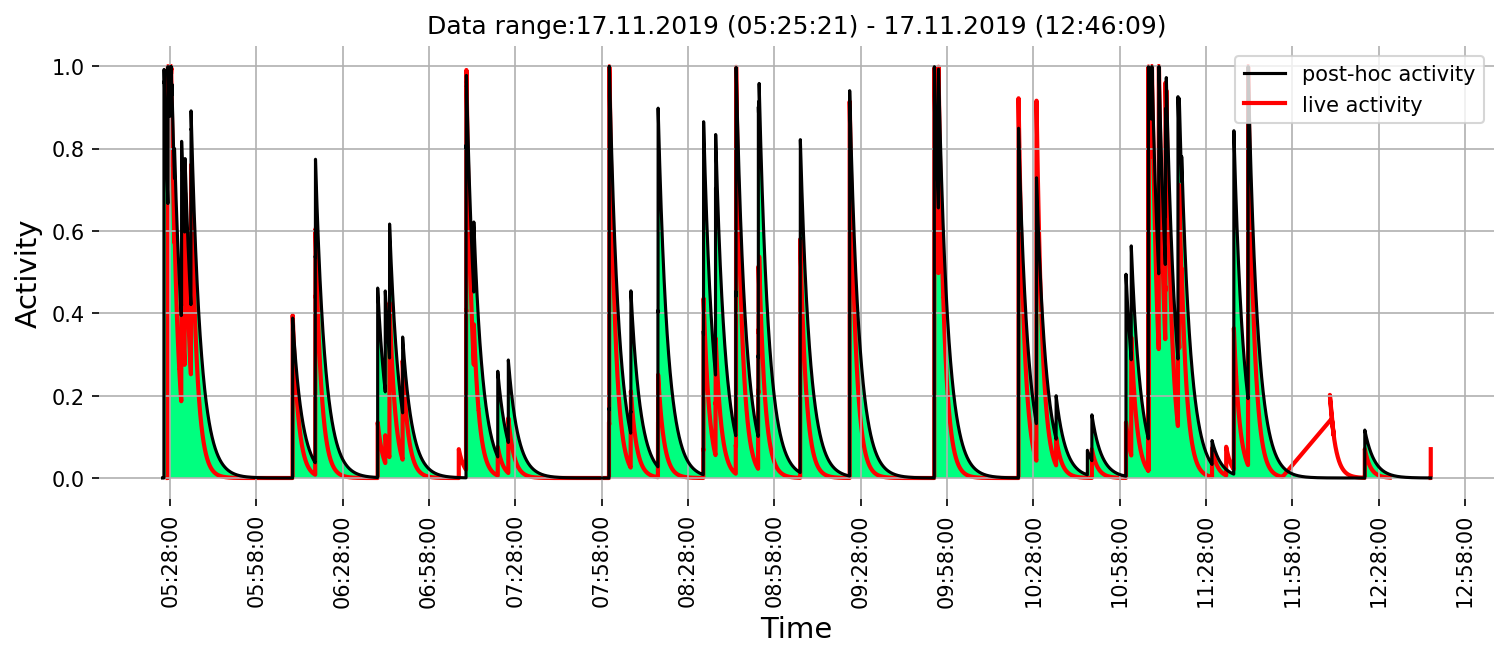

In [1744]:
plt.figure(figsize=(12, 4), dpi=(150))
plt.plot(even_hours, activity, 'k', label='post-hoc activity')

plt.title("Data range:{} - {}".format(even_hours[0].strftime('%d.%m.%Y (%H:%M:%S)'), even_hours[-1].strftime('%d.%m.%Y (%H:%M:%S)')))
ax = plt.gca()
plt.gca().xaxis.set_tick_params(rotation=90)
plt.gca().xaxis.set_major_locator(hours)
plt.gca().xaxis.set_major_formatter(h_fmt)
plt.gca().fill_between(even_hours, 0, activity, facecolor='springgreen')

plt.plot(selected_df['time'], selected_df['activity'], 'r', lw = 2, zorder=1, label='live activity')
plt.legend()

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.xlabel("Time", fontsize=14)
plt.grid()
plt.ylabel("Activity", fontsize=14)
plt.show()

(0, 1)

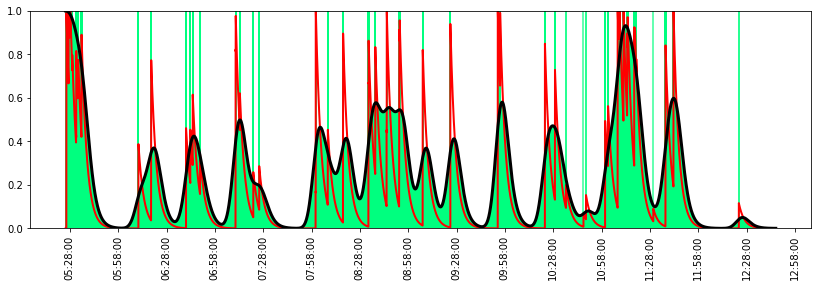

In [1745]:
import scipy.ndimage

skip_every = 50

filtered_data = scipy.ndimage.gaussian_filter(activity[::skip_every], sigma=20 * 1000 / skip_every) 
filtered_data /= np.max(filtered_data)

plt.figure(figsize=(14, 4))

plt.plot(even_hours[::skip_every], activity[::skip_every], c='r', lw=2)

plt.vlines(even_hours[np.argwhere(even_diff>thr)], 0, 1, color='springgreen', zorder=1, alpha=0.8)

#plt.plot(even_hours[::skip_every], even_diff[::skip_every]/np.max(even_diff[::skip_every])*10, c='C0', alpha=0.4)


plt.plot(even_hours[::skip_every], filtered_data, c='k', lw=3)


plt.gca().xaxis.set_tick_params(rotation=90)
plt.gca().xaxis.set_major_locator(hours)
plt.gca().xaxis.set_major_formatter(h_fmt)
plt.gca().fill_between(even_hours[::skip_every], 0, filtered_data, facecolor='springgreen')


plt.ylim(0, 1)

(0, 1)

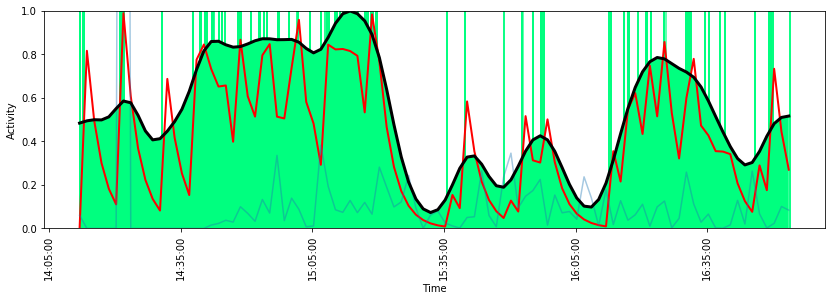

In [1566]:
import scipy.ndimage

skip_every = 10000

filtered_data = scipy.ndimage.gaussian_filter(activity[::skip_every], sigma=20 * 1000 / skip_every) 
filtered_data /= np.max(filtered_data)

plt.figure(figsize=(14, 4))

plt.plot(even_hours[::skip_every], activity[::skip_every], c='r', lw=2)

plt.vlines(even_hours[np.argwhere(even_diff>thr)], 0, 1, color='springgreen', zorder=1, alpha=0.8)

plt.plot(even_hours[::skip_every], even_diff[::skip_every]/np.max(even_diff[::skip_every])*10, c='C0', alpha=0.4)


plt.plot(even_hours[::skip_every], filtered_data, c='k', lw=3)

plt.ylabel("Activity")
plt.xlabel("Time")

plt.gca().xaxis.set_tick_params(rotation=90)
plt.gca().xaxis.set_major_locator(hours)
plt.gca().xaxis.set_major_formatter(h_fmt)
plt.gca().fill_between(even_hours[::skip_every], 0, filtered_data, facecolor='springgreen')


plt.ylim(0, 1)

In [1567]:
(even_hours[-1]-even_hours[0]).seconds

9752

In [1568]:
print("Len filtered: {} (fs = {:.4}), len original: {}".format(len(filtered_data), len(filtered_data)/(even_hours[-1]-even_hours[0]).seconds, len(activity)))

Len filtered: 98 (fs = 0.01005), len original: 975204


(0, 1)

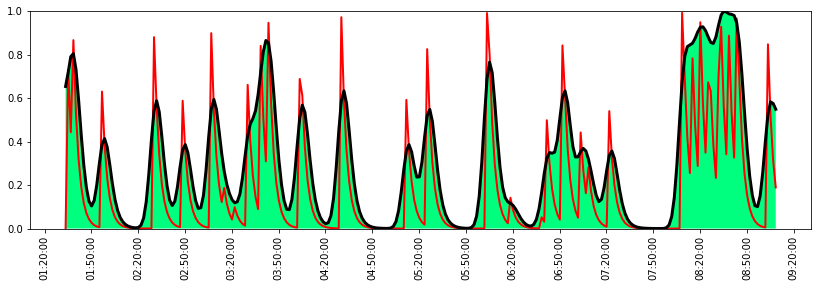

In [1495]:
plt.figure(figsize=(14, 4))

plt.plot(even_hours[::skip_every], activity[::skip_every], c='r', lw=2)

#plt.vlines(even_hours[np.argwhere(even_diff>thr)], 0, 1, color='springgreen', zorder=1, alpha=0.8)

#plt.plot(even_hours[::skip_every], even_diff[::skip_every]/np.max(even_diff[::skip_every])*10, c='C0', alpha=0.4)


plt.plot(even_hours[::skip_every], filtered_data, c='k', lw=3)


plt.gca().xaxis.set_tick_params(rotation=90)
plt.gca().xaxis.set_major_locator(hours)
plt.gca().xaxis.set_major_formatter(h_fmt)
plt.gca().fill_between(even_hours[::skip_every], 0, filtered_data, facecolor='springgreen')


plt.ylim(0, 1)

# Linear model with adaptive sampling frequency

In [74]:
ts = np.array(selected_df['t'])
times = np.array(selected_df['t_realtime'])
diffs = np.array(selected_df['diff'])

thresh = 12.5
decay = 2 * 60 * 1000.0
spike_strength = 0.07
decay_delay = 5 * 60 * 1000.0

dt = 1.0
last_dt = 1.0

activity = 0.0
t_lastspike = 0

acts = [0]
states = [0]

def detect_state(activity):
    if activity < 0.01:
        return 1
    else:
        return 0
last_spike = times[-1]
for i in range(1, len(ts)):
    dt = times[i] - times[i-1]
    diff = diffs[i]
    now = times[i]
    
    if diff > thresh:
        activity += (1 - activity) * spike_strength
        last_spike = now
        
    if now - last_spike > decay_delay:
        activity += - activity / decay * dt
    
    if activity < 0:
        activity = 0
        
    states.append(detect_state(activity))
    acts.append(activity)
acts = np.array(acts)
states = np.array(states)

In [75]:
# find periods of inactivity
#states = np.ones((len(acts)))
#states = np.array(acts) > 0.02
#print((len(states)-sum(states)) / len(states))
print("Percent deep sleep: {:.2}".format(len(states[states==1])/ len(states)))

Percent deep sleep: 0.19


In [76]:
up_downs = np.where(np.diff(np.array(states).astype(int))==-1)[0]
up_downs = np.insert(up_downs, 0, 0)
down_ups = np.where(np.diff(np.array(states).astype(int))==1)[0]

up_downs = np.where(np.diff(np.array(states).astype(int))==-1)[0]
up_downs = np.insert(up_downs, 0, 0)
down_ups = np.where(np.diff(np.array(states).astype(int))==1)[0]

up_downs = np.where(np.diff(np.array(states).astype(int))==-1)[0]
up_downs = np.insert(up_downs, 0, 0)
down_ups = np.where(np.diff(np.array(states).astype(int))==1)[0]

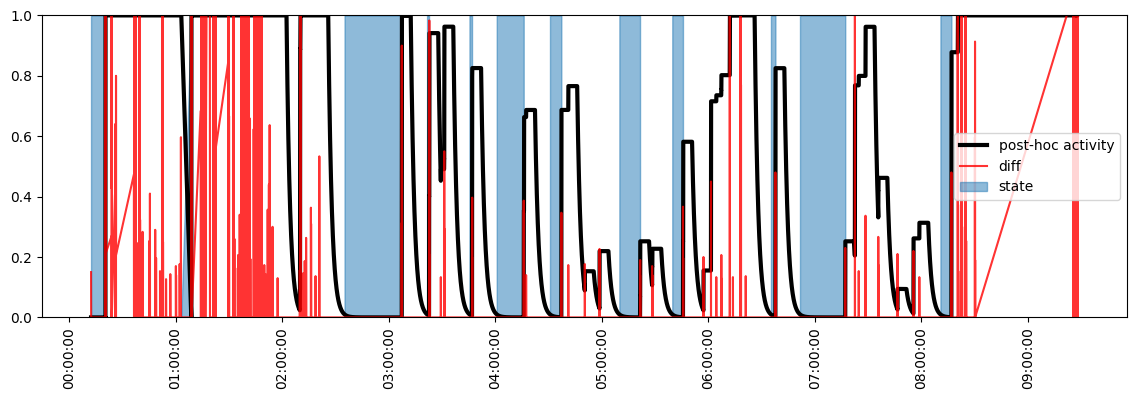

In [80]:
plt.figure(figsize=(14, 4), dpi=100)
plt.plot(selected_df['time'][:len(acts)], acts, c='k', lw=3, label='post-hoc activity')
#plt.gca().fill_between(selected_df['time'][:len(acts)], 0, acts, color='C3', alpha=0.5)

plt.plot(selected_df['time'][:len(acts)], (diffs[:len(acts)])*(diffs[:len(acts)]>thresh)/100, color='r', alpha=0.8, zorder=2, label='diff')

#plt.plot(selected_df['time'][:len(acts)], states, c='r', lw=3, alpha=0.8)
plt.ylim(0, 1)
plt.gca().fill_between(selected_df['time'][:len(acts)], 0, states, color='C0', alpha=0.5, label='state')
#plt.plot(selected_df['time'][:len(acts)], diffs[:len(acts)]/1000, c='k')

#plt.plot(selected_df['time'], selected_df['activity'], 'k', lw = 2, zorder=3, label='live activity')
plt.legend()

hours = mdates.HourLocator(interval = 1)
h_fmt = mdates.DateFormatter('%H:%M:%S')
plt.gca().xaxis.set_tick_params(rotation=90)
plt.gca().xaxis.set_major_locator(hours)
plt.gca().xaxis.set_major_formatter(h_fmt)
#plt.gca().fill_between(even_hours[::skip_every], 0, filtered_data, facecolor='springgreen')
#plt.plot(even_hours[::skip_every], filtered_data, c='springgreen', lw=3)

# Load data from hdf

In [140]:
import h5py
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime
import numpy as np
import os

In [146]:
os.chdir('interface/')

In [67]:
h5f = h5py.File(filename, mode='r')
runs = list(h5f.keys())
print(runs)
print(h5f[runs[-1]].keys())

['2019-11-22-01H-32M-44S', '2019-11-22-09H-25M-34S', '2019-11-22-21H-18M-27S', '2019-11-23-01H-47M-03S', '2019-11-26-02H-02M-33S', '2019-12-02-22H-17M-25S', '2019-12-02-23H-07M-16S', '2019-12-02-23H-11M-21S', '2019-12-02-23H-27M-43S', '2019-12-03-00H-06M-39S', '2019-12-03-01H-19M-24S', '2019-12-03-01H-39M-22S', '2019-12-03-01H-51M-22S', '2019-12-03-01H-53M-26S', '2019-12-03-01H-56M-24S', '2019-12-03-01H-56M-49S', '2019-12-03-02H-00M-04S', '2019-12-03-02H-04M-27S', '2019-12-03-02H-05M-01S', '2019-12-03-02H-05M-10S', '2019-12-03-02H-05M-55S', '2019-12-03-02H-06M-07S', '2019-12-03-02H-08M-21S', '2019-12-03-02H-09M-59S', '2019-12-03-02H-10M-40S', '2019-12-03-02H-14M-42S', '2019-12-03-02H-15M-12S', '2019-12-03-02H-15M-19S', '2019-12-03-02H-16M-10S', '2019-12-03-02H-16M-24S', '2019-12-03-02H-16M-34S', '2019-12-03-02H-16M-43S', '2019-12-03-02H-16M-57S', '2019-12-03-02H-17M-09S', '2019-12-03-02H-24M-43S', '2019-12-03-02H-30M-38S', '2019-12-03-02H-34M-00S', '2019-12-03-02H-34M-21S', '2019-12-03

In [185]:
STATIC_IMAGES_DIR = 'app/static/images/'

def plot_last_runs(nRuns = 10, filename = "../log.h5"):
    with h5py.File(filename, mode='r') as h5f:
        runs = list(h5f.keys())
    runs = runs[-nRuns:][::-1]
    for r in runs:
        plot_recording(runName = r, filename = filename)
    return runs
def plot_recording(rInd = -1, runName = None, filename = "../log.h5"):
    if runName is None:
        with h5py.File(filename, mode='r') as h5f:
            runs = list(h5f.keys())
        runName = runs[rInd]
        
    image_dir = os.path.join(STATIC_IMAGES_DIR, "{}.png".format(runName))
    if os.path.isfile(image_dir):
        print("File {} exists... loading {}".format(image_dir, runName))
    else:
        with h5py.File(filename, mode='r') as h5f:
            runs = list(h5f.keys())
            if runName is None:
                runName = runs[rInd]
            print("Rendering {}".format(runName))

            ts = h5f[runName]['ts_realtime'][()]
            diffs = h5f[runName]['diffs'][()]
            acts = h5f[runName]['acts'][()]

        times = []
        for i, milli in enumerate(ts):
            times.append(datetime.datetime.fromtimestamp(milli/1000.0))
        times = np.array(times)

        fig = plt.figure(figsize=(14, 4), dpi=100)
        plt.title(runName)
        ax = fig.add_subplot(1, 1, 1)

        ax.plot(times, acts, c='k', lw=3)
        ax.fill_between(times, 0, acts, color='C0', alpha=0.4, label='state')

        thr = 17
        ax.vlines(times[np.argwhere(diffs>thr)], 0, 1, color='red', zorder=1, alpha=0.3)

        ax.set_ylim(0, 1)

        hours = mdates.HourLocator(interval = 1)
        h_fmt = mdates.DateFormatter('%H:%M:%S')
        ax.xaxis.set_tick_params(rotation=90)
        ax.xaxis.set_major_locator(hours)
        ax.xaxis.set_major_formatter(h_fmt)

        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        #ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
        #ax.tick_params(direction='out', length=4, width=1, colors='k', labelsize=6)

        #plt.grid()
        #plt.show()
        plt.savefig(image_dir, bbox_inches='tight')
        return fig


In [186]:
plot_last_runs(3)

File app/static/images/2019-12-04-08H-55M-25S.png exists... loading 2019-12-04-08H-55M-25S
File app/static/images/2019-12-04-01H-05M-08S.png exists... loading 2019-12-04-01H-05M-08S
File app/static/images/2019-12-04-00H-57M-55S.png exists... loading 2019-12-04-00H-57M-55S


['2019-12-04-08H-55M-25S', '2019-12-04-01H-05M-08S', '2019-12-04-00H-57M-55S']

In [119]:
h5f.close()

In [190]:
print(int(None))

TypeError: int() argument must be a string, a bytes-like object or a number, not 'NoneType'